### **INITIALIZATION**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**LIBRARIES AND DEPENDENCIES**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [4]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES: 
from fastbook import *                                  # Getting all the Libraries. 
from fastai.callback.fp16 import *
from fastai.vision.all import *                         # Getting all the Libraries.

### **GETTING THE DATA**
- I will use [**Biwi Kinect Head Pose**](https://icu.ee.ethz.ch/research/datsets.html) dataset here. There are 24 directories numbered from 01 to 24 which correspond to different people photographed. 

In [5]:
#@ GETTING THE DATA: 
path = untar_data(URLs.BIWI_HEAD_POSE)                  # Getting Path to Dataset. 
path.ls()                                               # Inspecting Dataset. 

(#50) [Path('/root/.fastai/data/biwi_head_pose/06.obj'),Path('/root/.fastai/data/biwi_head_pose/io_sample.cpp'),Path('/root/.fastai/data/biwi_head_pose/12'),Path('/root/.fastai/data/biwi_head_pose/02.obj'),Path('/root/.fastai/data/biwi_head_pose/04.obj'),Path('/root/.fastai/data/biwi_head_pose/01'),Path('/root/.fastai/data/biwi_head_pose/24'),Path('/root/.fastai/data/biwi_head_pose/09'),Path('/root/.fastai/data/biwi_head_pose/03'),Path('/root/.fastai/data/biwi_head_pose/23')...]

In [6]:
#@ INSPECTING THE DATA: 
(path/"01").ls()                                        # Inspecting a Directory. 

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00134_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00342_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00143_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00145_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00350_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00053_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00354_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00439_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00061_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00205_pose.txt')...]

**Note:**
- Inside the subdirectories there are different frames. Each of them comes with an image i.e _rgb.jpg and a pose file i.e _pose.txt. I will write a function that converts an image file name to its associated pose file. 

In [7]:
#@ PREPARING THE DATASET: 
img_files = get_image_files(path)                       # Getting all Images. 
def img2pose(x): 
    return Path(f"{str(x)[:-7]}pose.txt")               # Getting Pose Files. 
img2pose(img_files[0])                                  # Inspecting Pose Files. 

Path('/root/.fastai/data/biwi_head_pose/12/frame_00722_pose.txt')

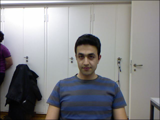

In [9]:
#@ INSPECTING THE IMAGES: 
im = PILImage.create(img_files[0])                      # Getting an Image. 
im.shape                                                # Inspecting the Shape. 
im.to_thumb(160)                                        # Inspecting the Image. 

In [10]:
#@ EXTRACTING HEAD CENTER POINT: 
cal = np.genfromtxt(path/"01"/"rgb.cal", skip_footer=6)  # Loading Data. 
def get_ctr(f):                                          # Function for Getting Centers. 
    ctr = np.genfromtxt(img2pose(f), skip_header=3)      # Loading Data. 
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1, c2])
#@ IMPLEMENTATION OF FUNCTION: 
get_ctr(img_files[0])                                    # Inspecting the Coordinates. 

tensor([355.8862, 234.0857])

### **INITIALIZING DATABLOCK AND DATALOADERS**

In [11]:
#@ INITIALIZING DATABLOCK: 
biwi = DataBlock(blocks=(ImageBlock, PointBlock),                       # Initializing Blocks. 
                 get_items=get_image_files,                             # Getting Images. 
                 get_y=get_ctr,                                         # Getting Coordinates. 
                 splitter=FuncSplitter(lambda o: o.parent.name=="13"),  # Splitting Images. 
                 batch_tfms=[*aug_transforms(size=(240, 320)),
                             Normalize.from_stats(*imagenet_stats)])    # Batch Transformations. 

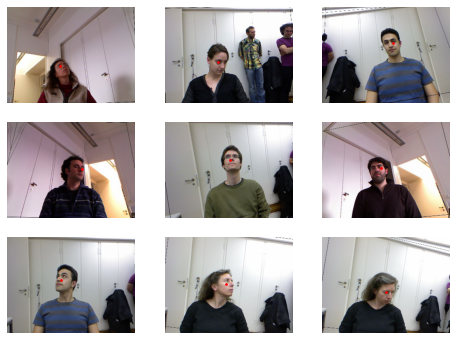

In [13]:
#@ INITIALIZING DATALOADERS: 
dls = biwi.dataloaders(path)                                            # Initializing DataLoaders. 
dls.show_batch(max_n=9, figsize=(8, 6))                                 # Inspecting Batches. 

In [14]:
#@ INSPECTING TENSORS: 
xb, yb = dls.one_batch()                         # Getting a Batch of Images. 
xb.shape, yb.shape                               # Inspecting Shape. 

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [24]:
#@ INSPECTING RANGE: 
yb[0]                                            # Inspecting Target Range. 

TensorPoint([[0.4257, 0.2294]], device='cuda:0')

### **TRAINING THE MODEL**

In [17]:
#@ TRAINING THE MODEL: 
learn = cnn_learner(dls, resnet18, y_range=(-1, 1))     # Initializing Convolutions. 

In [18]:
#@ DEFINING SIGMOID RANGE FUNCTION: 
def sigmoid_range(x, lo, hi):                           # Defining the Function. 
    return torch.sigmoid(x) * (hi - lo) + lo            # Implementation of Sigmoid and Range. 

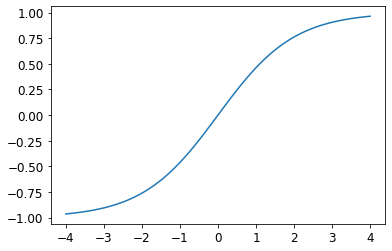

In [20]:
#@ INSPECTING SIGMOID RANGE FUNCTION: 
plot_function(partial(sigmoid_range, lo=-1, hi=1), 
              min=-4, max=4)                            # Inspecting the Function. 

In [21]:
#@ INSPECTING DEFAULT LOSS FUNCTION: 
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0030199517495930195)

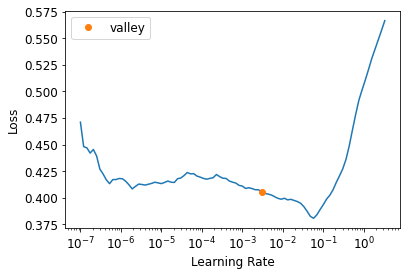

In [22]:
#@ GETTING OPTIMAL LEARNING RATE: 
learn.lr_find()

In [23]:
#@ TRAINING THE MODEL WITH OPTIMAL LR: 
lr = 0.0030199517495930195                              # Initializing Optimal LR. 
learn.fit_one_cycle(5, lr)                              # Training the Model. 

epoch,train_loss,valid_loss,time
0,0.117398,0.008735,02:00
1,0.014101,0.007909,01:59
2,0.007935,0.002098,01:58
3,0.004913,0.001086,01:58
4,0.003434,0.000731,02:01


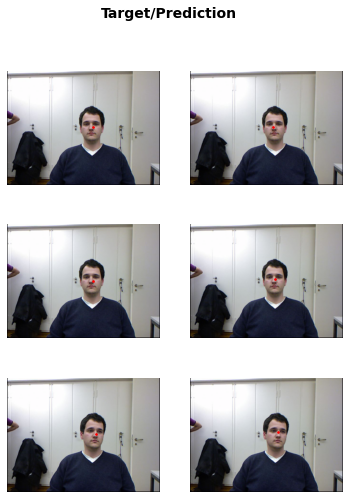

In [33]:
#@ INSPECTING THE RESULTS: 
learn.show_results(ds_idx=1, max_n=3, 
                   figsize=(6, 8))                      # Inspecting Results. 

**Note:**
- **nn.CrossEntropyLoss** for single label classification. 
- **nn.BCEWithLogitsLoss** for multi label classification. 
- **nn.MSELoss** for regression. 